In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
interventions_df = pd.read_csv("interventions.tsv",sep='\t',index_col=0 )
outputs_df = pd.read_csv("outputs.tsv",sep='\t',index_col=0)
individuals_df = pd.read_csv("individuals.tsv",sep='\t',index_col=[0,1],header=[0,1] )
groups_df = pd.read_csv("groups.tsv",sep='\t',index_col=[0,1],header=[0,1] )
subjects_df = pd.read_csv("all_subjects.tsv",sep='\t',index_col=[0,1,2],header=[0,1] )


In [3]:
def convert_unit(df, unit_in, unit_out, factor=1.0, 
                 unit_field="unit", data_fields=['mean','median','value', 'sd', 'se', 'min', 'max'], inplace=True, subset=False):
    """ Unit conversion in given data frame. """
    if not inplace:
        df = df.copy()
    if subset:
        is_weightidx =  df[subset].notnull()
        df =  df[is_weightidx]     
    if isinstance(factor, pd.Series):
        factor = factor[is_weightidx]
        
        
    idx = (df[unit_field] == unit_in)
    

    for key in data_fields:
        df.loc[idx, key] = df.loc[idx, key]*factor
    df.loc[idx, unit_field] = unit_out
    
    if subset:
        return df[idx]
    
    return df
    

# thalf & tmax [min] -> [h]
convert_unit(outputs_df, unit_in='min', unit_out='h', factor=1/60.0)
# cmax [mg/l] -> [µg/ml]
convert_unit(outputs_df, unit_in='mg/l', unit_out='µg/ml', factor=1.0)
# clearance ['ml/h/kg'] -> ['ml/min/kg']
convert_unit(outputs_df, unit_in='ml/h/kg', unit_out='ml/min/kg', factor=1/60.0)

convert_unit(outputs_df, unit_in='l/h/kg', unit_out='ml/min/kg', factor=1000/60.0)

convert_unit(outputs_df, unit_in='l/h', unit_out='ml/min', factor=1000.0/60)

# auc ['mg/l*min'] -> ['mg/l*h']
convert_unit(outputs_df, unit_in='mg/l*min', unit_out='mg/l*h', factor=1/60.0)
# auc ['mg/l*h'] -> ['µg/ml*h']
convert_unit(outputs_df, unit_in='mg/l*h', unit_out='µg/ml*h', factor=1.0)
# overview of units for given pktype
pktypes = sorted(outputs_df.pktype.unique())
print('-'*80)
print('PKPD data ({})'.format(len(outputs_df)))
print('-'*80)
for pktype in pktypes:
    data = outputs_df[outputs_df.pktype==pktype]
    print('{:<6} {:<20}{}'.format(len(data), pktype, sorted(data.unit.unique())))
print('-'*80)

--------------------------------------------------------------------------------
PKPD data (4932)
--------------------------------------------------------------------------------
99     auc_end             ['mg*h/l', 'ng*h/ml']
498    auc_inf             ['mg*h/l', 'ng*h/ml', 'nmol*h/l', 'pmol/ml*h', 'µg*min/ml', 'µmol*h/l', 'µmol/l*h']
999    clearance           ['ml/min', 'ml/min/1.73m^2', 'ml/min/kg']
186    clearance_renal     ['ml/min']
2      clearance_unbound   ['ml/min/kg']
406    cmax                ['ng/ml', 'nmol/l', 'pmol/ml', 'µg/ml', 'µmol/l']
295    concentration       ['nmol/l', 'µg/ml']
1      fraction_absorbed   ['-']
5      kabs                ['1/h']
99     kel                 ['1/h']
2      plasma_binding      ['-']
425    ratio               ['-']
594    recovery            ['%', '-']
681    thalf               ['h']
390    tmax                ['h']
250    vd                  ['l', 'l/kg']
---------------------------------------------------------------------------

In [4]:

individuals_df.loc[(individuals_df["sex"]["choice"] == "M"),("oral contraceptives","choice")] = "N"
groups_df.loc[(groups_df["sex"]["choice"] == "M"),("oral contraceptives","choice")] = "N"

#df.loc[idx, unit_field] = unit_out

## Merging datasets

In [5]:
print(len(outputs_df), 'pkpd outputs')
# merge with dose information
pk = pd.merge(left=outputs_df, right=interventions_df,  how='inner', suffixes=('','_intervention'),left_on='interventions', right_on="pk")
print(len(pk), 'merge interventions')

# merge with subject information
pk_i = pd.merge(pk,individuals_df.reset_index(),  how='inner', suffixes=('','individual'),left_on='individual_pk', right_on="subject_pk")
pk_g = pd.merge(pk,groups_df.reset_index(),  how='inner', suffixes=('','group'),left_on='group_pk', right_on="subject_pk")
print(len(pk_i), 'merge individuals')
print(len(pk_g), 'merge groups')
print(len(pk_i)+len(pk_g), 'both')

4932 pkpd outputs
4932 merge interventions
3378 merge individuals
1554 merge groups
4932 both


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [6]:
# filter caffeine clearance healthy
#& (pk_i.application == "single dose") \

idx = (pk_i.substance_name_intervention == 'caffeine') \
       & (pk_i.substance_name == 'caffeine') \
       & (pk_i[ ('healthy', 'choice')] == 'Y')\
       & (pk_i[ 'tissue'] == 'plasma') 
    
pk_i = pk_i[idx]
print("Number of measurements for individuals with selected criteria:" ,len(pk_i))

Number of measurements for individuals with selected criteria: 870


In [7]:
pk_i_realtive = convert_unit(pk_i,
                             unit_in="mg",
                             unit_out="mg/kg", 
                             factor=1.0/pk_i[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'], 
                             subset=("weight","value"))

print("Number of measurements for individuals with selected criteria:" ,len(pk_i_realtive))

pk_i_absolute = convert_unit(pk_i,
                             unit_in="mg/kg",
                             unit_out="mg", 
                             factor=pk_i[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'],
                             subset=("weight","value"))
print("Number of measurements for individuals with selected criteria:" ,len(pk_i_absolute))

pk_i = pd.concat([pk_i,pk_i_realtive,pk_i_absolute], ignore_index=True)
print("Number of measurements for individuals with selected criteria:" ,len(pk_i))

pk_i_realtive = convert_unit(pk_i,
                             unit_in="ml/min",
                             unit_out="ml/min/kg", 
                             factor=1.0/pk_i[("weight","value")],
                             unit_field="unit", 
                             data_fields=['value'], 
                             subset=("weight","value"))

print("Number of measurements for individuals with selected criteria:" ,len(pk_i_realtive))

pk_i_absolute = convert_unit(pk_i,
                             unit_in="ml/min/kg",
                             unit_out="ml/min", 
                             factor=pk_i[("weight","value")],
                             unit_field="unit", 
                             data_fields=['value'],
                             subset=("weight","value"))
print("Number of measurements for individuals with selected criteria:" ,len(pk_i_absolute))

pk_i = pd.concat([pk_i,pk_i_realtive,pk_i_absolute], ignore_index=True)
print("Number of measurements for individuals with selected criteria:" ,len(pk_i))

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Number of measurements for individuals with selected criteria: 654
Number of measurements for individuals with selected criteria: 0
Number of measurements for individuals with selected criteria: 1524
Number of measurements for individuals with selected criteria: 96
Number of measurements for individuals with selected criteria: 204
Number of measurements for individuals with selected criteria: 1824


In [8]:
idx = (pk_g.substance_name_intervention == 'caffeine') \
       & (pk_g.substance_name == 'caffeine') \
       & (pk_g[ ('healthy', 'choice')] == 'Y') \
       & (pk_g[ 'tissue'] == 'plasma')
    
pk_g = pk_g[idx]
print("Number of measurements for groups with selected criteria:" ,len(pk_g))

Number of measurements for groups with selected criteria: 445


In [9]:
pk_g_realtive = convert_unit(pk_g,
                             unit_in="mg",
                             unit_out="mg/kg", 
                             factor=1.0/pk_g[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'], 
                             subset=("weight","value"))

print("Number of measurements for individuals with selected criteria:" ,len(pk_g_realtive))

pk_g_absolute = convert_unit(pk_g,
                             unit_in="mg/kg",
                             unit_out="mg", 
                             factor=pk_g[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'],
                             subset=("weight","value"))
print("Number of measurements for individuals with selected criteria:" ,len(pk_g_absolute))

pk_g = pd.concat([pk_g,pk_g_realtive,pk_g_absolute], ignore_index=True)
print("Number of measurements for individuals with selected criteria:" ,len(pk_g))

pk_g_realtive = convert_unit(pk_g,
                             unit_in="ml/min",
                             unit_out="ml/min/kg", 
                             factor=1.0/pk_g[("weight","value")],
                             unit_field="unit", 
                             subset=("weight","value"))

print("Number of measurements for individuals with selected criteria:" ,len(pk_g_realtive))

pk_g_absolute = convert_unit(pk_g,
                             unit_in="ml/min/kg",
                             unit_out="ml/min", 
                             factor=pk_g[("weight","value")],
                             unit_field="unit", 
                             subset=("weight","value"))
print("Number of measurements for individuals with selected criteria:" ,len(pk_g_absolute))

pk_g = pd.concat([pk_g,pk_g_realtive,pk_g_absolute], ignore_index=True)
print("Number of measurements for individuals with selected criteria:" ,len(pk_g))

Number of measurements for individuals with selected criteria: 24
Number of measurements for individuals with selected criteria: 0
Number of measurements for individuals with selected criteria: 469
Number of measurements for individuals with selected criteria: 0
Number of measurements for individuals with selected criteria: 8
Number of measurements for individuals with selected criteria: 477


In [85]:
print("Individuals")
print("unit intervetion:")
print(pk_i.unit_intervention.unique())

# absolute dose
idx_dose_abs_i = (pk_i.unit_intervention == 'mg')
# clearance per bodyweight
idx_dose_rel_i = (pk_i.unit_intervention == 'mg/kg')


Individuals
unit Intervetion:
['mg' 'mg/kg']


In [11]:
print("Groups")
print("unit intervetion:")
print(pk_g.unit_intervention.unique())

# absolute dose
idx_dose_abs_g = (pk_g.unit_intervention == 'mg')
# clearance per bodyweight
idx_dose_rel_g = (pk_g.unit_intervention == 'mg/kg')

Groups
unit dose:
['mg' 'mg/kg']


In [12]:
#individuals_df = individuals_df[individuals_df["oral contraceptives"]["choice"]=="Y"]
#pk_i = pd.merge(pk,individuals_df.reset_index(),  how='inner', suffixes=('','subject'),left_on='individual_pk', right_on="subject_pk")


In [13]:
#pk_i[("oral contraceptives","choice")]

In [146]:
# Styles for plots
ccolors = {'control': 'black',
           'smoking': 'blue',
           'oc': 'green',
          }
markers = {'control': 's',
           'smoking': 'o',
           'oc': 'o',
          }

cateogry_filter = {
    'control':{
        ('smoking', 'choice'):"N",
        ('oral contraceptives', 'choice'):'N'},
    'smoking':{
        ('smoking', 'choice'):"Y"}, 
    'oc':{
        ('oral contraceptives', 'choice'):'Y'}
}    


In [165]:
ccolors = {'men': 'black',
           'female': 'blue',
           
          }
markers = {'men': 's',
           'female': 'o',
          }

cateogry_filter = {
    'men':{
        ('sex', 'choice'):"M"},
    'female':{
        ('sex', 'choice'):"F"}    
}    


In [166]:
#ccolors = {'homo sapiens': 'black',
#           
#          }
#markers = {'homo sapiens': 's',
#          }
#
#cateogry_filter = {
#    'homo sapiens':{
#        ('species', 'choice'):"homo sapiens"}, 
#}    


In [167]:
def data_pktype(pktype, pk):
    data = pk[pk.pktype==pktype]
    print('{} ({})'.format(pktype, len(data)))
    print("units:", data.unit.unique())
    return data
    
# clearance data
print("Individuals")
cl_data_i = data_pktype('clearance', pk_i)
# absolute clearance
idx_cl_abs_i = (cl_data_i.unit == 'ml/min')
# clearance per bodyweight
idx_cl_rel_i = (cl_data_i.unit == 'ml/min/kg')

# clearance data
print("Groups")
cl_data_g = data_pktype('clearance', pk_g)
# absolute clearance
idx_cl_abs_g = (cl_data_g.unit == 'ml/min')
# clearance per bodyweight
idx_cl_rel_g = (cl_data_g.unit == 'ml/min/kg')

Individuals
clearance (780)
units: ['ml/min/kg' 'ml/min']
Groups
clearance (87)
units: ['ml/min/kg' 'ml/min' 'ml/min/1.73m^2']


In [168]:
cl_data_i.groupby("unit")["value"].count()

unit
ml/min       423
ml/min/kg    354
Name: value, dtype: int64

In [169]:

cl_data_g.groupby("unit")["mean"].count()

unit
ml/min            33
ml/min/1.73m^2     4
ml/min/kg         49
Name: mean, dtype: int64

In [170]:
def filter_df(filter_dict, df):
    for filter_key, filter_value in filter_dict.items():
        df = df[df[filter_key]==filter_value]
    return df

In [171]:
for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,cl_data_i)
        print(category, len(df_category))

men 384
female 206


In [172]:
#individuals_df["oral contraceptives"].groupby("choice").count()

In [173]:
pk_i.groupby(("oral contraceptives","choice")).get_group("Y").groupby("pktype").count()

,tissue,interventions,substance_name,unit,individual_pk,value,group_pk,mean,se,cv,...,"(caffeine, count)","(alcohol, count)","(medication type, choice)","(medication type, count)","(CYP2D6 genotype, choice)","(CYP2D6 genotype, count)","(alcohol abstinence, choice)","(alcohol abstinence, count)","(alcohol abstinence, unit)","(alcohol abstinence, value)"
pktype,,,,,,,,,,,,,,,,,,,,,
auc_end,4,4,4,4,4,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
clearance,17,17,17,17,17,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cmax,4,4,4,4,4,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
thalf,13,13,13,13,13,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tmax,4,4,4,4,4,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
vd,13,13,13,13,13,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


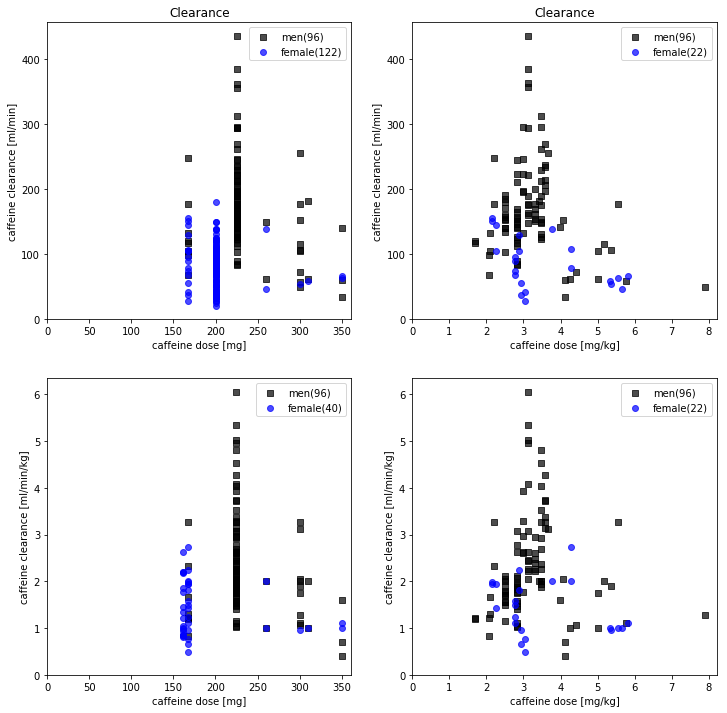

In [179]:

# plot caffeine clearance
data = cl_data_i
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

dinds = [idx_dose_abs_i & idx_cl_abs_i,
         idx_dose_rel_i & idx_cl_abs_i,
         idx_dose_abs_i & idx_cl_rel_i,
         idx_dose_rel_i & idx_cl_rel_i]
for ax, inds in zip((ax1, ax2, ax3, ax4), dinds):
    df = data[inds]
    
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        #x = df_category[("age","value")]

        y = df_category.value
        ax.scatter(x, y,color=ccolors[category], marker=markers[category], label=f"{category}({len(x)})", alpha=0.7)
        #sns.distplot( y,ax =ax,color=ccolors[category],  label=f"{category}({len(x)})",kde_kws={'clip': (0.0,100000 )})

        #for i, txt in enumerate(df_category[('study', '')]):
        #    ax.annotate(txt, (x.iloc[[i]],
        #                      y.iloc[[i]]), alpha=0.7)
    
for ax in (ax1, ax2, ax3, ax4):
    ax.set_ylim(bottom=0)
    ax.legend()



for ax in (ax1, ax2):
    ax.set_title('Clearance')
    ax.set_ylabel('caffeine clearance [ml/min]')
    #ax.set_ylim([0, 300])
    ax.set_ylim(bottom=0)

    
for ax in (ax3, ax4):
    ax.set_ylabel('caffeine clearance [ml/min/kg]')
    #ax.set_ylim([0, 5])
    ax.set_ylim(bottom=0)

for ax in (ax1, ax3):
    #ax.set_xlim(0, 500)
    ax.set_xlabel('caffeine dose [mg]')
    ax.set_xlim(left=0)

for ax in (ax2, ax4):
    #ax.set_xlim(0, 11)
    ax.set_xlim(left=0)

    ax.set_xlabel('caffeine dose [mg/kg]')

In [157]:
for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,cl_data_g)
        print(category, len(df_category))

control 20
smoking 16
oc 4


In [158]:
#cl_data_g.groupby([('oral contraceptives', 'choice'),('smoking', 'choice')])["mean"].count()
#len(cl_data_g)
#cl_data_g.groupby(('smoking', 'choice'))
#cl_data_g[[('smoking', "count"),('oral contraceptives', "count")]]

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


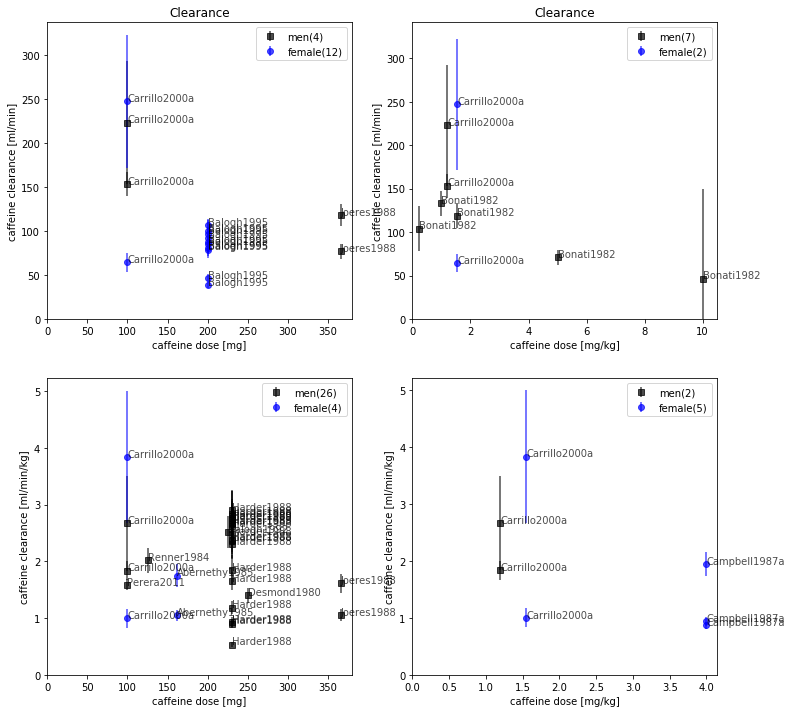

In [180]:
# plot caffeine clearance
data = cl_data_g[cl_data_g["mean"].notnull()]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

dinds = [idx_dose_abs_g & idx_cl_abs_g,
         idx_dose_rel_g & idx_cl_abs_g,
         idx_dose_abs_g & idx_cl_rel_g,
         idx_dose_rel_g & idx_cl_rel_g]
for ax, inds in zip((ax1, ax2, ax3, ax4), dinds):
    df = data[inds]
    
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        y = df_category["mean"]
        yerr = df_category["se"]
        #sns.distplot( y,ax =ax,color=ccolors[category],  label=f"{category}({len(x)})",kde_kws={'clip': (0.0,100000 )})

        ax.errorbar(x, y,yerr=yerr,color=ccolors[category], fmt=markers[category],  label=f"{category}({len(x)})", alpha=0.7)
        for i, txt in enumerate(df_category[('study', '')]):
            ax.annotate(txt, (x.iloc[[i]],
                              y.iloc[[i]]), alpha=0.7)
    
for ax in (ax1, ax2, ax3, ax4):
    ax.set_ylim(bottom=0)
    ax.legend()

for ax in (ax1, ax2):
    ax.set_title('Clearance')
    ax.set_ylabel('caffeine clearance [ml/min]')
    #ax.set_ylim([0, 300])
    ax.set_ylim(bottom=0)

    
for ax in (ax3, ax4):
    ax.set_ylabel('caffeine clearance [ml/min/kg]')
    #ax.set_ylim([0, 5])
    ax.set_ylim(bottom=0)

for ax in (ax1, ax3):
    #ax.set_xlim(0, 500)
    ax.set_xlabel('caffeine dose [mg]')
    ax.set_xlim(left=0)

for ax in (ax2, ax4):
    #ax.set_xlim(0, 11)
    ax.set_xlim(left=0)

    ax.set_xlabel('caffeine dose [mg/kg]')